In [4]:
import sys
import numpy as np
from pyDOE import lhs
import torch
from torch import Tensor, ones, stack, load
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import pandas as pd
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from scipy import stats
from tesladatapinn import TeslaDatasetPinn
from pathlib import Path
import wandb
import time

# Import PINNFramework
sys.path.append("...") 
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [5]:
# Use cuda if it is available, else use the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Preprocessing

In [7]:
# # login wandb
# wandb.login()

# # Initialize WandB 
# wandb.init(name='pinn_run', 
#            project='pinn_project',
#            #notes='This is a test run', 
#            #tags=['Fashion MNIST', 'Test Run'],
#            #entity='arkalim'
#            )

# WandB Configurations (optional)
wandb.config.normalize = 1
wandb.config.batch_size= 1   
wandb.config.lr = 1e-4
wandb.config.ic_weight = 1
wandb.config.dt_weight = 10000

# Create instance of the dataset
id = -1
ds = TeslaDatasetPinn(battery_level = True, ID = id, data = 'train', diff = "central_diff",device = device, normalize = wandb.config.normalize)


# trainloader
train_loader = DataLoader(ds, batch_size=wandb.config.batch_size,shuffle=False)

model = pf.models.MLP(input_size=5,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=ds.lb, 
                      ub=ds.ub,
                      #activation = torch.relu
                      )
model.to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=wandb.config.lr)
criterion = torch.nn.MSELoss()

# Log the network weight histograms (optional)
# wandb.watch(model)

(445266, 10)


## Function for evaluating the derivative

In [6]:
def derivative(x, u):

    grads = ones(u.shape, device=u.device) # move to the same device as prediction
    grad_u = grad(u, x, create_graph=True, grad_outputs=grads )[0]
   
    # calculate first order derivatives       
    u_t = grad_u[:, 4]
       
    u_t = u_t.reshape(-1, 1)

    return u_t

## Function for writing a checkpoint during training

In [ ]:
def write_checkpoint(checkpoint_path, epoch, min_mlp_loss, optimizer):
    checkpoint = {}
    checkpoint["epoch"] = epoch
    checkpoint["minimum_pinn_loss"] = min_mlp_loss
    checkpoint["optimizer"] = optimizer.state_dict()
    checkpoint["mlp_model"] = model.state_dict()
    torch.save(checkpoint, checkpoint_path)

## Training of the PINN

In [ ]:
x_data_plot=[]
y_data_all_plot=[]
y_data_1_plot=[]
y_data_2_plot=[]

# Set fixed random number seed
torch.manual_seed(1234)

start_epoch = 0
epochs = 3000
min_mlp_loss = np.inf


begin = time.time()
for epoch in range(epochs):
    # Print epoch
    print(f'Starting epoch {epoch}')
    
    # Set current and total loss value
    current_loss = 0.0
    total_loss = 0.0
    total_loss1 = 0.0
    total_loss2 = 0.0
    
    #model.train() 
    for i, data in enumerate(train_loader,0):
        
        x_batch, y_batch, temp,ids = data
        optimizer.zero_grad()

        x_batch = torch.squeeze(x_batch, 0)
        y_batch = torch.squeeze(y_batch, 0)
        temp = torch.squeeze(temp, 0)
        
        x0 = x_batch[0,:]
        
        x_batch.requires_grad=True
        u_pred = model(x_batch.to(device))

        u_t = derivative(x_batch,u_pred)*wandb.config.normalize
        u0 = model(x0.to(device))
        #u0 = u_pred[0,:] #.reshape(-1, 1)
        temp = temp[0, :] #.reshape(-1, 1)

        loss1 = criterion(u_t.squeeze(),y_batch.squeeze())*wandb.config.dt_weight
        loss2 = criterion(u0.to(device),temp.to(device))*wandb.config.ic_weight

        loss = loss1+loss2

        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        total_loss += loss.item()
        total_loss1 += loss1.item()
        total_loss2 += loss2.item()

        if i % 50 == 49:
            print('Loss after mini-batch %5d: %.8f' %
                  (i + 1, current_loss / 50))
            current_loss = 0.0

    
    Loss = total_loss/(i+1)
    Loss1 = total_loss1/(i+1)
    Loss2 = total_loss2/(i+1)
    print("Epoch ", epoch, "Total Loss ", Loss )
    print("Epoch ", epoch, "Loss 1 ", Loss1)
    print("Epoch ", epoch, "Loss 2", Loss2)

    x_data_plot.append(epoch)
    y_data_all_plot.append(Loss)
    y_data_1_plot.append(Loss1)
    y_data_2_plot.append(Loss2)
    
    # # save best model
    # if min_mlp_loss > Loss:
    #     print(f'Validation Loss Decreased({min_mlp_loss:.6f}--->{Loss:.6f}) \t Saving The Model')
    #     min_mlp_loss = Loss
    #     # Saving State Dict
    #     model_name_path = Path('pinnmodel/best_model_env_{}_{}.pt'.format(wandb.run.id, wandb.run.name))
    #     torch.save(model.state_dict(), model_name_path)
        
    # # writing checkpoint
    # if (epoch + 1) % 200 == 0:
    #     checkpoint_path = Path('pinnmodel/checkpoint_env_{}_{}_{}.pt'.format(wandb.run.id, wandb.run.name, epoch))
    #     write_checkpoint(checkpoint_path, epoch, min_mlp_loss, optimizer)
        
    # # Log the loss and accuracy values at the end of each epoch
    # wandb.log({
    #     "Epoch": epoch,
    #     "Total Loss": Loss,
    #     "Loss1 (time derivative)": Loss1,
    #     "Loss2 (Initial condition)": Loss2
    #     })
end = time.time()        
        




Starting epoch 0
Loss after mini-batch    50: 86.97614902
Epoch  0 Total Loss  237.34419154732123
Epoch  0 Loss 1  0.014308777087812221
Epoch  0 Loss 2 237.32988319448802
Starting epoch 1
Loss after mini-batch    50: 49.85300059
Epoch  1 Total Loss  143.729442394541
Epoch  1 Loss 1  0.028895611316724884
Epoch  1 Loss 2 143.70054689233962
Starting epoch 2
Loss after mini-batch    50: 62.04902669
Epoch  2 Total Loss  125.05232056327488
Epoch  2 Loss 1  0.03252157433954657
Epoch  2 Loss 2 125.01979860068177
Starting epoch 3
Loss after mini-batch    50: 70.11776949
Epoch  3 Total Loss  119.07773067101674
Epoch  3 Loss 1  0.034721764646667944
Epoch  3 Loss 2 119.04300901245163
Starting epoch 4
Loss after mini-batch    50: 72.14831983
Epoch  4 Total Loss  114.97073671723838
Epoch  4 Loss 1  0.04038217931638823
Epoch  4 Loss 2 114.9303548092468
Starting epoch 5
Loss after mini-batch    50: 58.52755081
Epoch  5 Total Loss  103.42775883088294
Epoch  5 Loss 1  0.06616308193825597
Epoch  5 Loss 2

KeyboardInterrupt: ignored

In [ ]:
print("Training time:", end - begin)

## Plots of Loss components against epochs

In [ ]:
# Make the plot of Total Loss vs epochs
dpi = 360
figure(figsize=(10, 8), dpi = dpi)
plt.plot(x_data_plot,y_data_all_plot)
plt.title('Training loss vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.show()

# Make the plot of the supervised loss
figure(figsize=(10, 8), dpi = dpi)
plt.plot(x_data_plot,y_data_1_plot)
plt.title('Training loss vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss1 (time derivative)')
plt.show()

# Make the plot of time stability loss
figure(figsize=(10, 8), dpi = dpi)
plt.plot(x_data_plot,y_data_2_plot)
plt.title('Training loss vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss2 (Initial condition)')
plt.show()

## Postprocessing -- Load the model


In [11]:
#PATH = '/pinnmodel/bl_false/best_model_env_3pgx07nw_pinn_run_env.pt' #battery level false le-4
PATH = '/pinnmodel/bl_true/best_model_env_1y8urr8f_pinn_run_env.pt' #battery level true 1e-4
#model.load_state_dict(torch.load(PATH))
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu'))) # use this if there is no gpu
model.eval()

MLP(
  (linear_layers): ModuleList(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Performance of the model on training data

time: 1.5502190589904785
MAE: 4.9060893
MSE: 35.827667
Relative error (%): 28.113362193107605


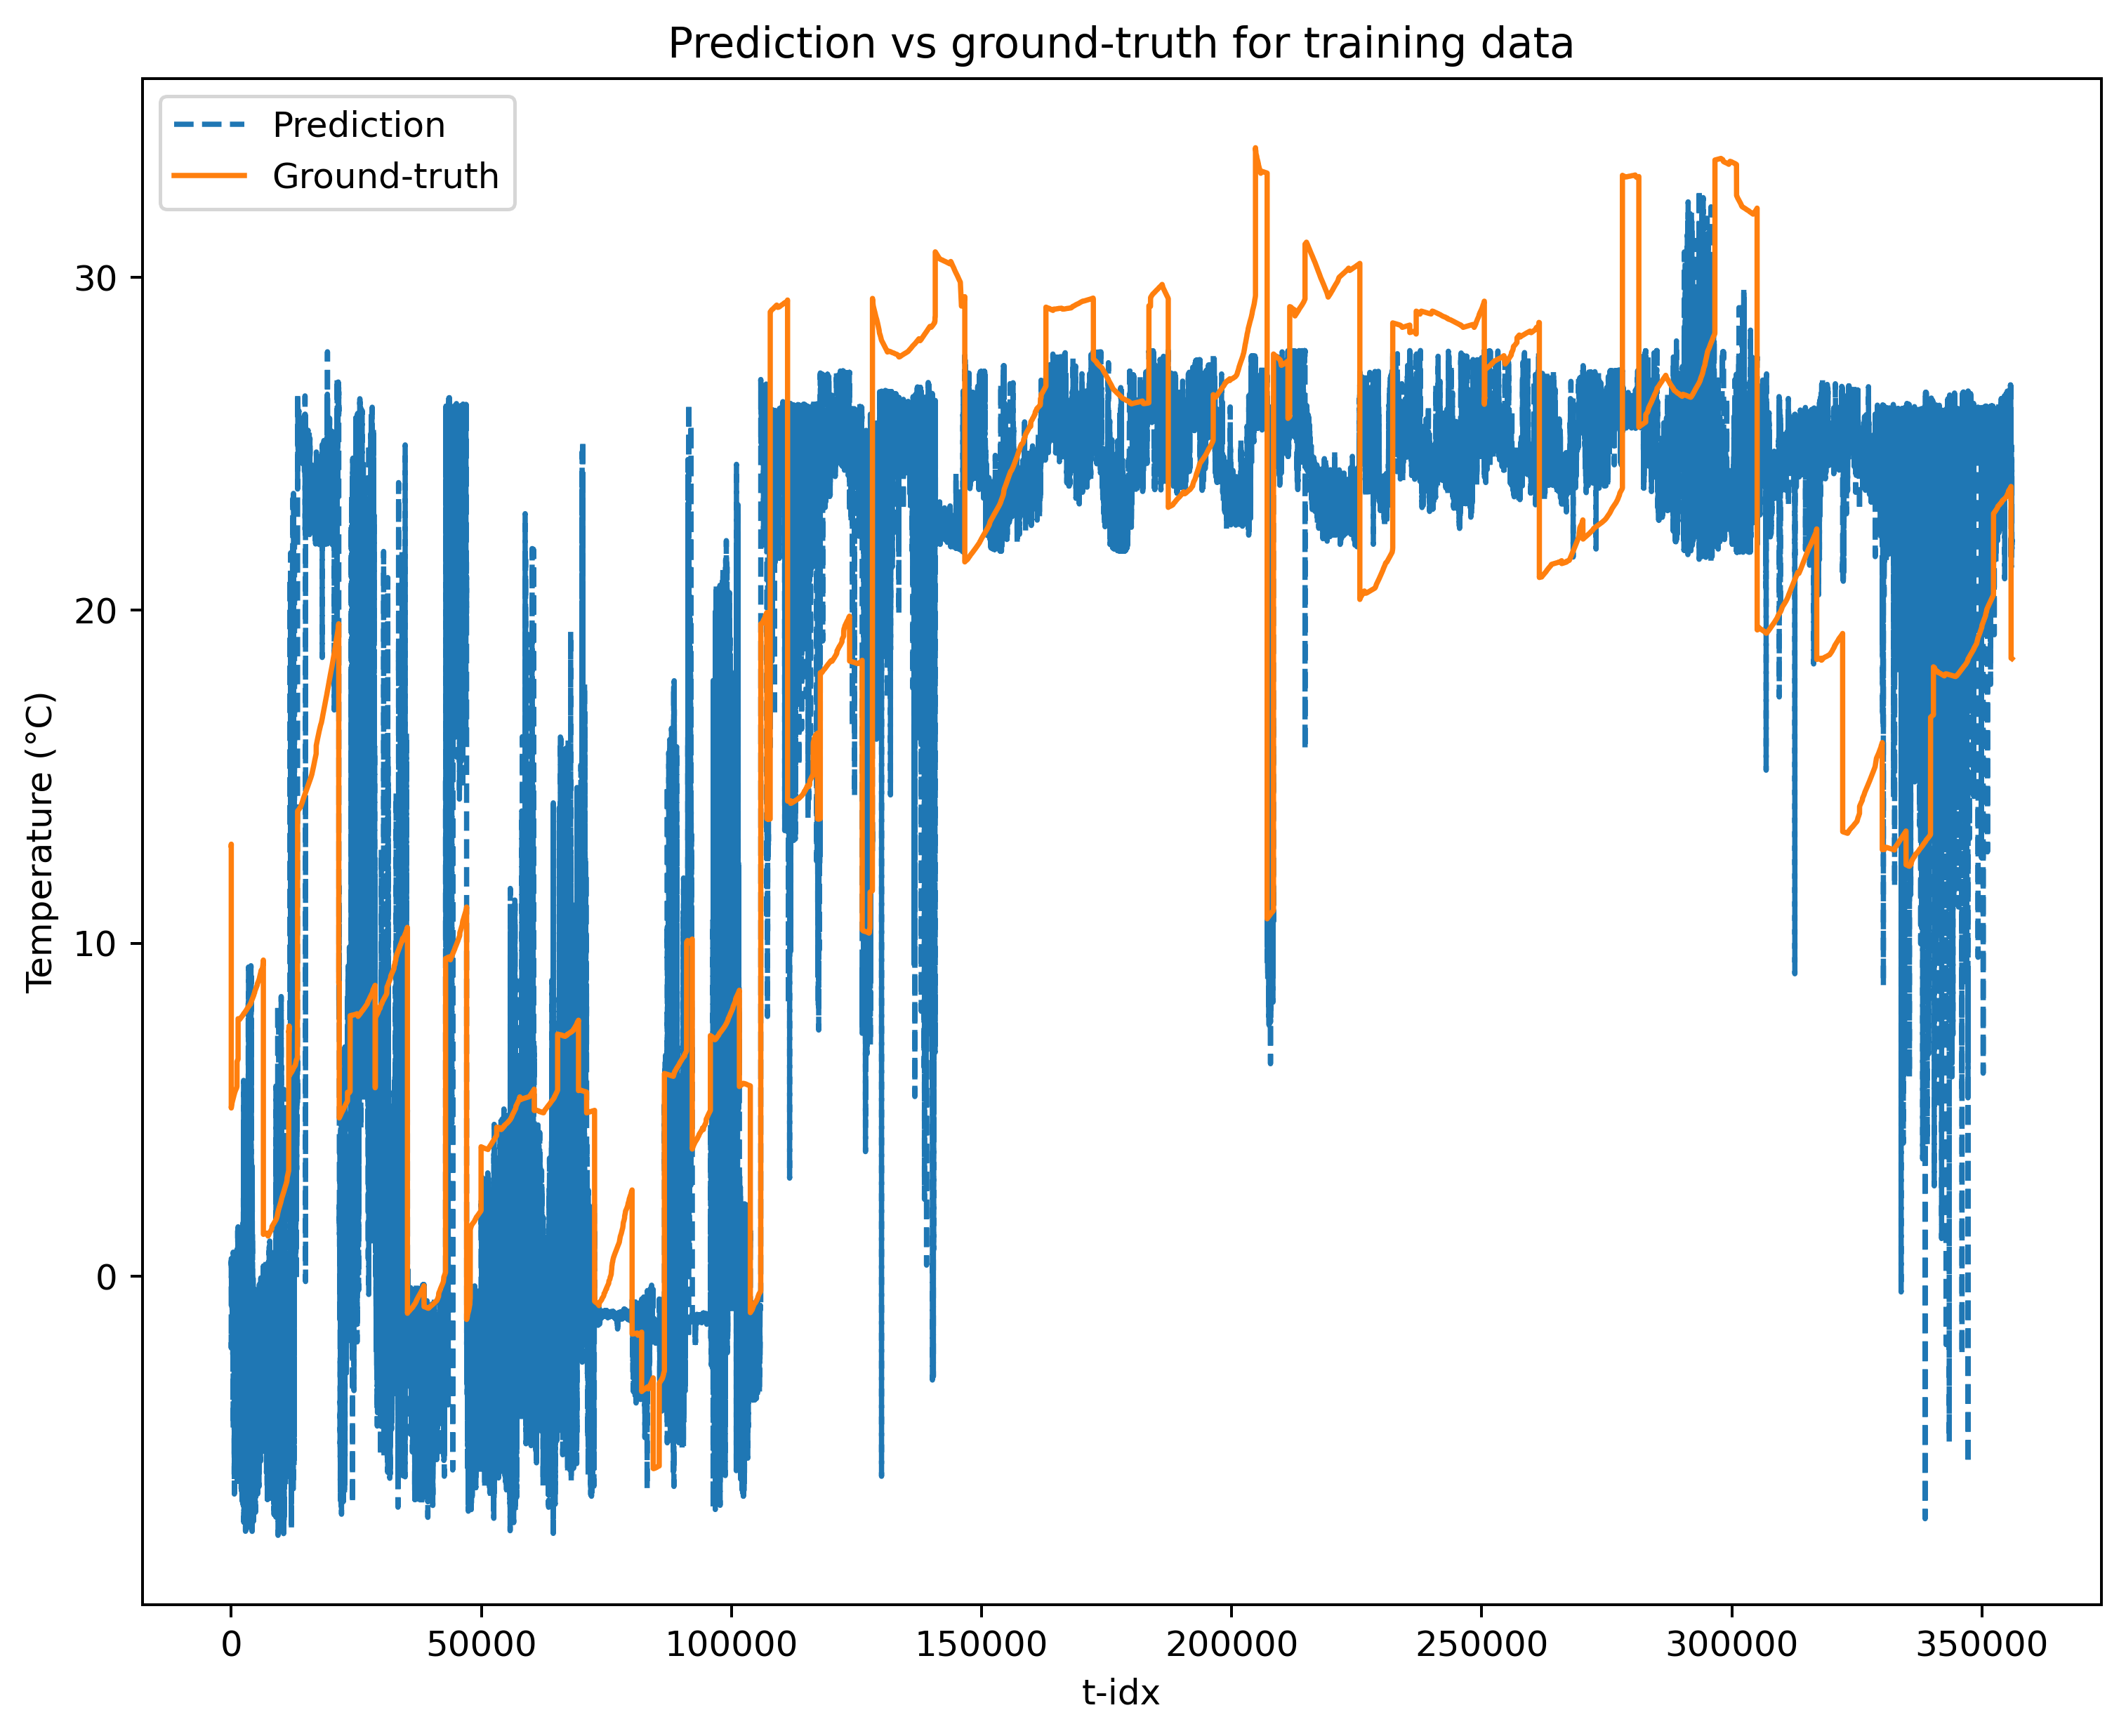

In [22]:
# Make a prediction
normalize = wandb.config.normalize

begin = time.time()
pred = model(ds.x.float().to(device)) #GPU

#pred = model(x_batch.float().to(device)) #GPU
end = time.time() 
print("time:", end - begin)
pred = pred.detach().cpu().numpy()/normalize

# ground-truth
gt = ds.temp.numpy()/normalize

# Some statistics on the model performance on all of dataset

mae = np.sum(np.abs(pred- gt).mean(axis=None))
print('MAE:', mae)

mse = ((gt - pred)**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(pred - gt) / np.linalg.norm(gt)
print('Relative error (%):', rel_error*100)


figure(figsize=(10, 8), dpi= 360)
plt.plot(pred, '--')
plt.plot(gt, '-')
plt.legend(['Prediction', 'Ground-truth'])
plt.title('Prediction vs ground-truth for training data')
plt.xlabel('t-idx')
plt.ylabel('Temperature (°C)')
plt.show()


# figure(figsize=(10, 8), dpi= 360)
# #time
# t=ds.t

# plt.plot(t,pred, '--')
# plt.plot(t,gt, '-')
# plt.legend(['Prediction', 'Ground-truth'])
# plt.title('Prediction vs ground-truth for training data')
# plt.xlabel('time / seconds')
# plt.ylabel('Temperature (°C)')
# plt.show()

## Function for evaluating the peformance of the model on test data

In [14]:
def evaluate(idd, bl):
    #idd = 88
    ds_test = TeslaDatasetPinn(device = device, normalize = wandb.config.normalize, battery_level = bl, ID = idd, data = 'test', diff = "central_diff")
    # Plot of predicted temperature against ground-truth temperature
    t = ds_test.t.numpy()

    true_temp = ds_test.temp.numpy()

    begin = time.time()
    #ds_test.x[:,2]=0
    pred_temp = model(ds_test.x.to(device))
    end = time.time() 
    print("time:", end - begin)
    pred_temp = pred_temp.detach().cpu().numpy()

    #print((pred_temp.shape))
    #print((true_temp.shape))

    #MAE
    mae = np.sum(np.abs(pred_temp- true_temp).mean(axis=None))
    print('MAE:', mae)

    #MSE
    mse = ((true_temp - pred_temp)**2).mean(axis=None)
    print('MSE:', mse)

    #Relative error
    rel_error = np.linalg.norm(pred_temp - true_temp) / np.linalg.norm(true_temp)
    print('Relative error (%):', rel_error*100)


    plt.figure(figsize = (12, 8))
    plt.plot(t, pred_temp, '--', label='PINN')
    plt.plot(t, true_temp, '-', label='Ground-truth')
    plt.title('PINN vs ground-truth for drive ID = {}'.format(idd))
    plt.xlabel('t (seconds)')
    plt.ylabel('Temperature (°C)')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()
    
     
  
    #derivative plots

    ds_test.x.requires_grad=True
    begin = time.time()

    pred = model(ds_test.x.float().to(device))/normalize
    #pred = pred.detach().cpu().numpy()/normalize
    end = time.time() 
    print("time:", end - begin)
    
    # ground-truth
    gt = ds_test.temp.numpy()/normalize

    u_t = derivative(ds_test.x,pred)
    figure(figsize=(10, 8), dpi= 360)

    t = ds_test.t.numpy()

    #print(u_t.shape)
    mae = np.sum(np.abs(u_t.detach().numpy() - ds_test.y.detach().numpy() ).mean(axis=None))
    print('MAE:', mae)

    mse = ((u_t.detach().numpy() - ds_test.y.detach().numpy())**2).mean(axis=None)
    print('MSE:', mse)

    rel_error = np.linalg.norm(u_t.detach().numpy() - ds_test.y.detach().numpy()) / np.linalg.norm(ds_test.y.detach().numpy())
    print('Relative error (%):', rel_error*100)

    plt.figure(figsize = (12, 8))
    plt.plot(t, u_t.detach().numpy(), '--', label='PINN')
    plt.plot(t, ds_test.y, '-', label='Ground-truth')
    plt.title('PINN vs ground-truth for drive-ID = {}'.format(idd))
    plt.xlabel('t (seconds)')
    plt.ylabel('ΔTemp/Δt (°C/s)')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


## Performance of the model on test data

(4901, 10)
time: 0.02058577537536621
MAE: 1.4651043
MSE: 3.0407722
Relative error (%): 37.57026493549347


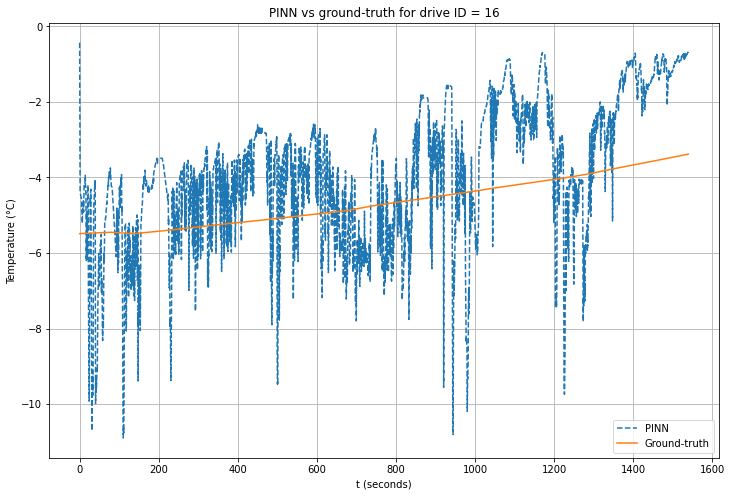

time: 0.027516603469848633
MAE: 0.0012156828
MSE: 1.7198953e-06
Relative error (%): 86.82265281677246


<Figure size 3600x2880 with 0 Axes>

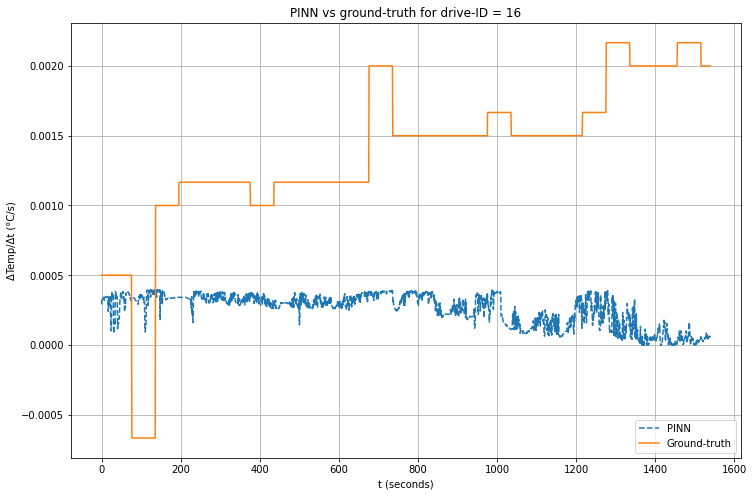

In [15]:
# # Test values = [16,39,47,52,72,81,88] 
bl = True
evaluate(idd=16, bl = bl)

(11259, 10)
time: 0.04132223129272461
MAE: 6.5072503
MSE: 45.153164
Relative error (%): 29.281243681907654


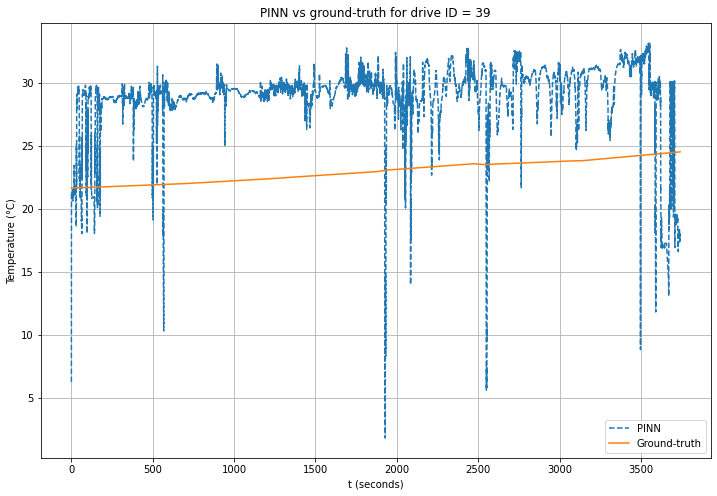

time: 0.049849748611450195
MAE: 0.001066684
MSE: 1.619375e-06
Relative error (%): 146.00411653518677


<Figure size 3600x2880 with 0 Axes>

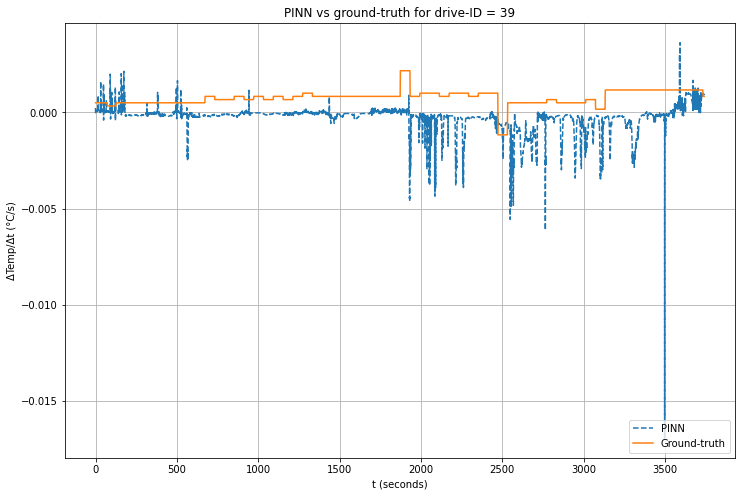

In [16]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=39, bl = bl)

(2440, 10)
time: 0.015496015548706055
MAE: 4.2670283
MSE: 47.189896
Relative error (%): 21.724918484687805


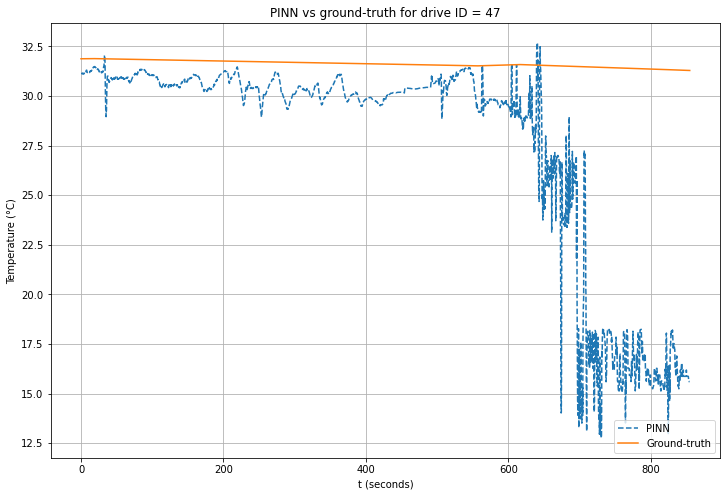

time: 0.014151811599731445
MAE: 0.0007843028
MSE: 8.035141e-07
Relative error (%): 95.30134201049805


<Figure size 3600x2880 with 0 Axes>

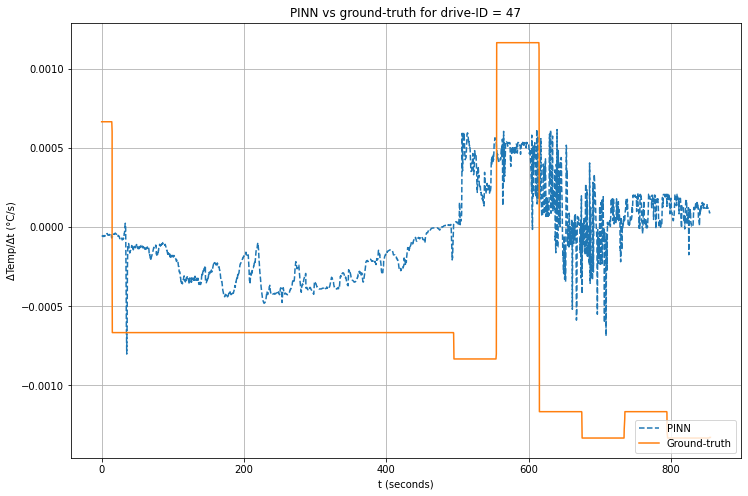

In [17]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=47, bl = bl)

(12741, 10)
time: 0.04895138740539551
MAE: 4.678712
MSE: 30.893373
Relative error (%): 26.763281226158142


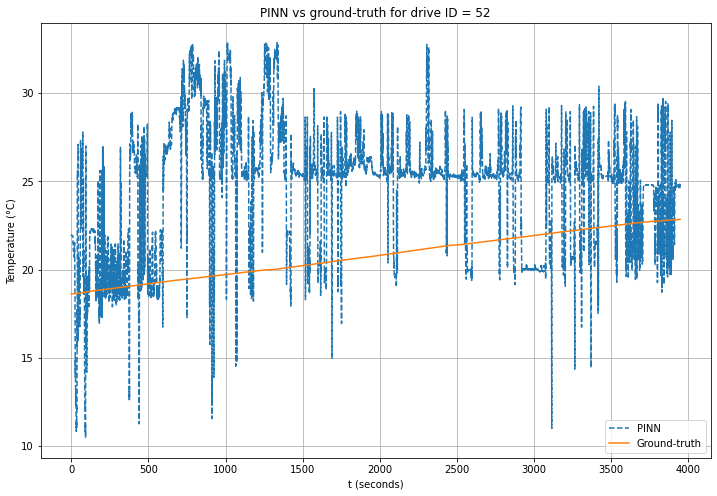

time: 0.06049489974975586
MAE: 0.0009615096
MSE: 1.0070286e-06
Relative error (%): 91.63254499435425


<Figure size 3600x2880 with 0 Axes>

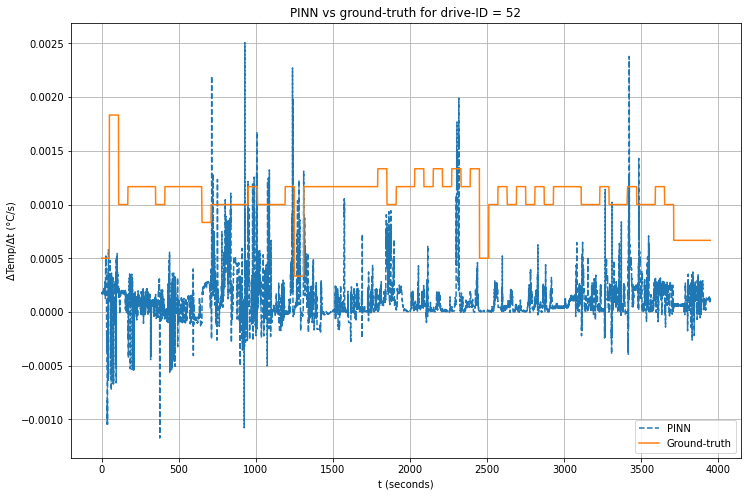

In [18]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=52, bl = bl)

(20002, 10)
time: 0.08012533187866211
MAE: 10.081617
MSE: 129.22475
Relative error (%): 66.14776253700256


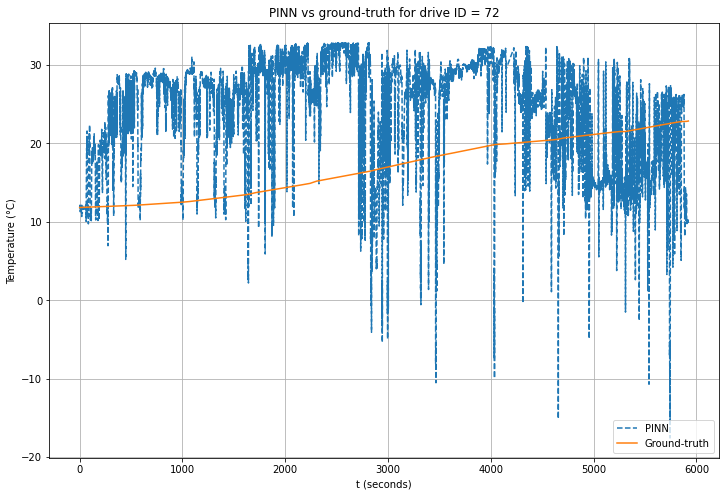

time: 0.08539485931396484
MAE: 0.0022760977
MSE: 7.419966e-06
Relative error (%): 131.47348165512085


<Figure size 3600x2880 with 0 Axes>

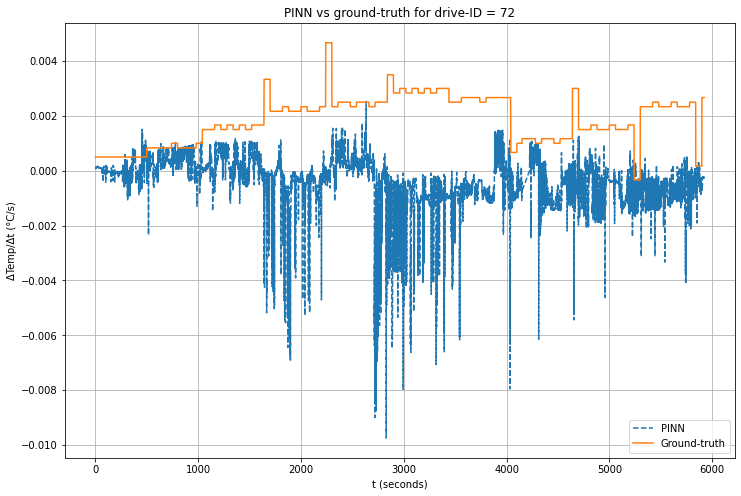

In [19]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=72, bl = bl)

(18267, 10)
time: 0.07195615768432617
MAE: 2.2946165
MSE: 6.7846847
Relative error (%): 9.064869582653046


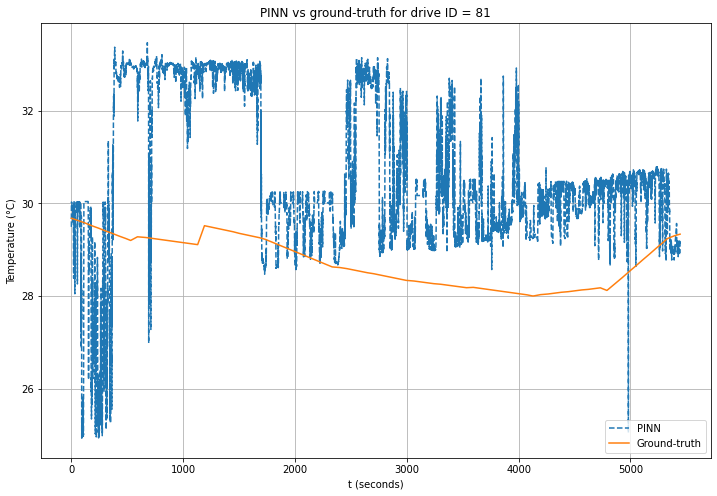

time: 0.07801485061645508
MAE: 0.0007851568
MSE: 1.3918028e-06
Relative error (%): 100.94704627990723


<Figure size 3600x2880 with 0 Axes>

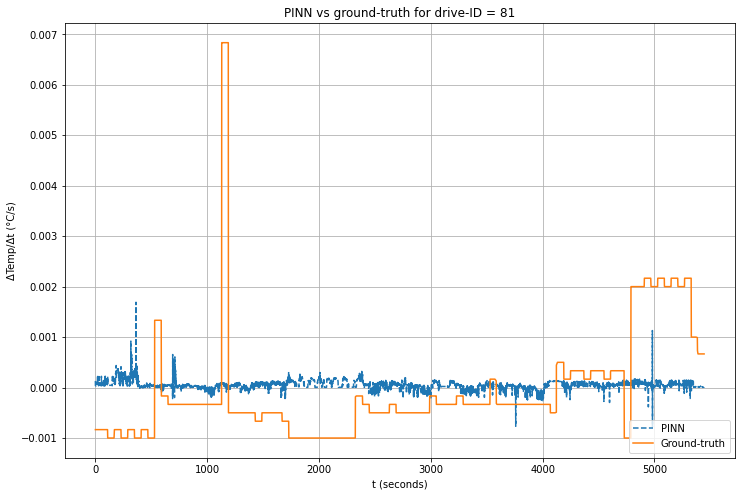

In [20]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=81, bl = bl)

(19418, 10)
time: 0.0696096420288086
MAE: 1.2432296
MSE: 3.148646
Relative error (%): 5.3000859916210175


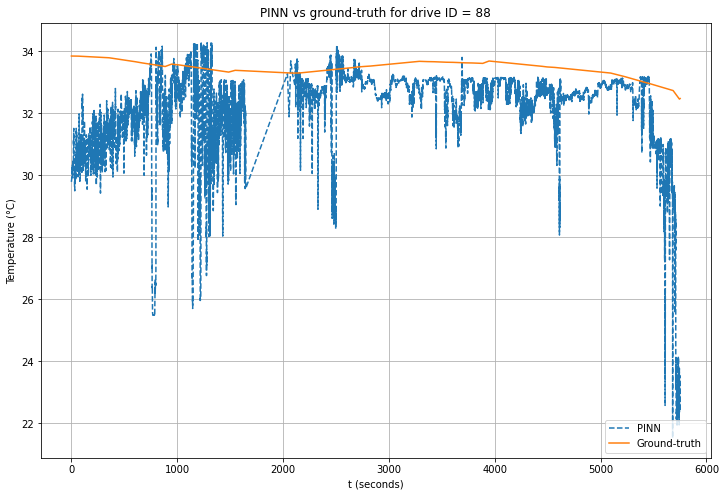

time: 0.07874822616577148
MAE: 0.00051949563
MSE: 5.6927354e-07
Relative error (%): 110.6421947479248


<Figure size 3600x2880 with 0 Axes>

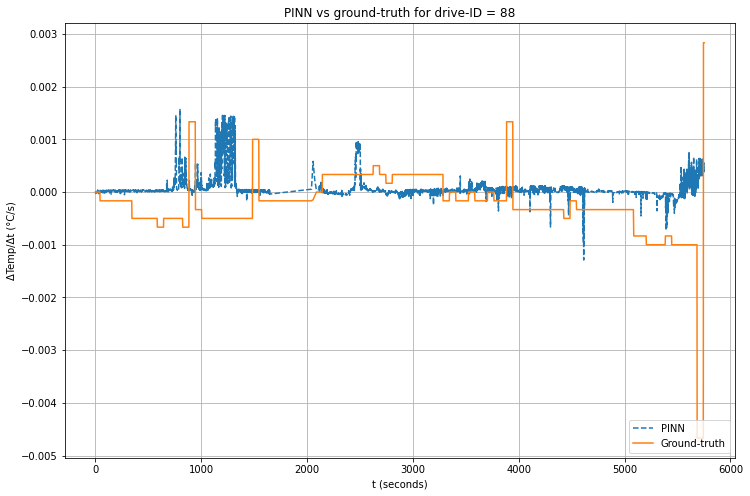

In [21]:
# # Test values = [16,39,47,52,72,81,88] 
evaluate(idd=88, bl = bl)